In [1]:
#import numpy as np
import pandas as pd
#import ace_tools as tools; 
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import warnings

#### The Data

In [2]:
df = pd.read_csv('data/Ventas_CapstoneProject.csv')

In [3]:
df.head()

,FechaEmision,Anio,Mes,Numero_Cliente,Nombre_Cliente,Tipo,Mov,MovId,Lote,Articulo,...,IVA,IEPS,IEPS_Cuota,ImporteTotal,Costo_Unitario,Costo_Total,Almacen,Linea,Rama,Modulo
0,10/02/2020,2020,2,160,HBS-DELLI DE MEXICO,Intercompañia,Factura,FUMA80,20A28S1A17G,DL00000068,...,8166.4,0.0,0,59206.4,298.7827,47805.232,UMAN10,COCTELES,INTERCOMPA,PROD
1,10/02/2020,2020,2,160,HBS-DELLI DE MEXICO,Intercompañia,Factura,FUMA82,20A20S2A17G,DL00000068,...,6124.8,0.0,0,44404.8,298.7827,35853.924,UMAN10,COCTELES,INTERCOMPA,PROD
2,10/02/2020,2020,2,160,HBS-DELLI DE MEXICO,Intercompañia,Factura,FUMA82,20A21S1A17G,DL00000068,...,1020.8,0.0,0,7400.8,298.7827,5975.654,UMAN10,COCTELES,INTERCOMPA,PROD
3,10/02/2020,2020,2,160,HBS-DELLI DE MEXICO,Intercompañia,Factura,FUMA82,20A28S1A17G,DL00000068,...,5104.0,0.0,0,37004.0,298.7827,29878.270,UMAN10,COCTELES,INTERCOMPA,PROD
4,18/02/2020,2020,2,160,HBS-DELLI DE MEXICO,Intercompañia,Factura,FUMA188,20A28S1A17G,DL00000068,...,2041.6,0.0,0,14801.6,298.7827,11951.308,UMAN10,COCTELES,INTERCOMPA,PROD


Prediccion de los articulos COMS y PROD

In [4]:
#Filtrando los articulos por Producidos o Importados
coms_data = df[df["Modulo"] == "COMS"].copy()
coms_data['FechaEmision'] = pd.to_datetime(coms_data['FechaEmision'], format='%d/%m/%Y')
prod_data = df[df['Modulo'] == 'PROD'].copy()
prod_data['FechaEmision'] = pd.to_datetime(prod_data['FechaEmision'], format='%d/%m/%Y')


# Calcular las ventas Mensuales por Articulo COMS
coms_monthly = coms_data.groupby([
    coms_data["FechaEmision"].dt.to_period('M'), "Articulo"])["Cantidad"].sum().unstack(fill_value=0)
# Calcular las ventas Mensuales por Articulo PROD
prod_monthly = prod_data.groupby([
    prod_data["FechaEmision"].dt.to_period('M'), "Articulo"])["Cantidad"].sum().unstack(fill_value=0)

# Establecer el indice  de tipo datetime
coms_monthly.index = coms_monthly.index.to_timestamp()
prod_monthly.index = prod_monthly.index.to_timestamp()


In [ ]:
# Mostrar datos calculados PROD
prod_monthly.head()


Articulo,DL00000068,DL00000679,DL00002467,DL00003018,DL00003022,DL00003896
FechaEmision,,,,,,
2020-02-01,1440.0,0.0,19140.0,0.0,0.0,0.0
2020-03-01,1890.0,0.0,26400.0,0.0,0.0,0.0
2020-04-01,-959.0,0.0,0.0,0.0,0.0,0.0
2020-05-01,80.0,0.0,0.0,0.0,0.0,0.0
2020-06-01,0.0,0.0,6600.0,0.0,0.0,0.0


In [6]:
# Mostrar datos calculados COMS
coms_monthly.head()


Articulo,DL00002500,DL00003413,DL00003522,DL00005485
FechaEmision,,,,
2020-06-01,8850.0,0.0,0.0,0.0
2020-11-01,35.0,0.0,0.0,0.0
2021-10-01,120.0,0.0,0.0,0.0
2021-11-01,34657.0,0.0,0.0,0.0
2021-12-01,28673.0,0.0,0.0,0.0


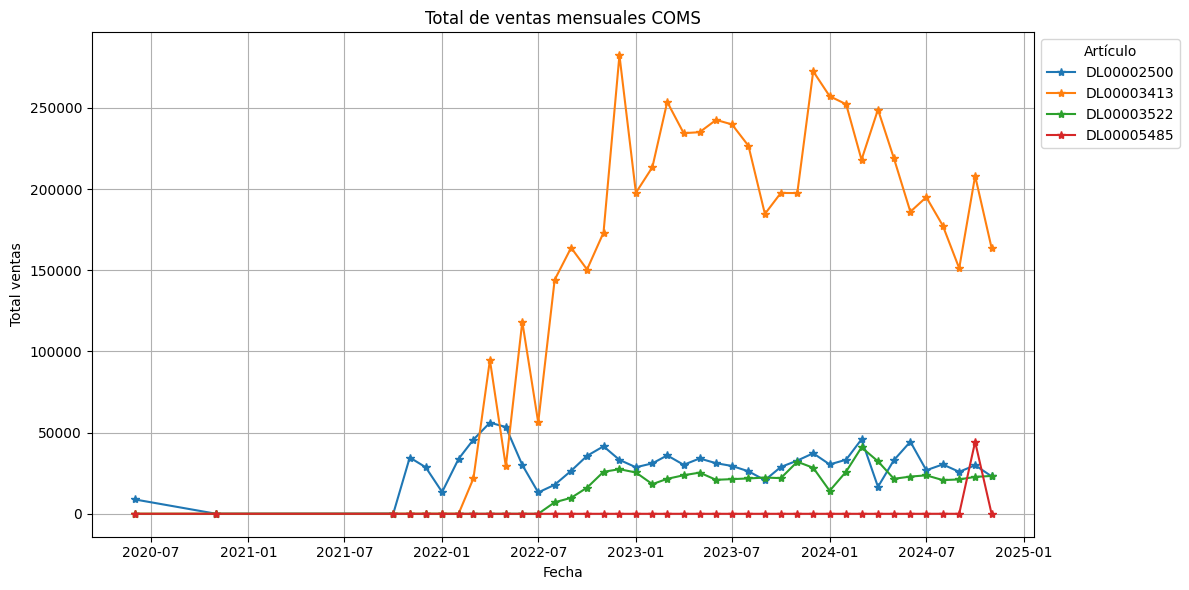

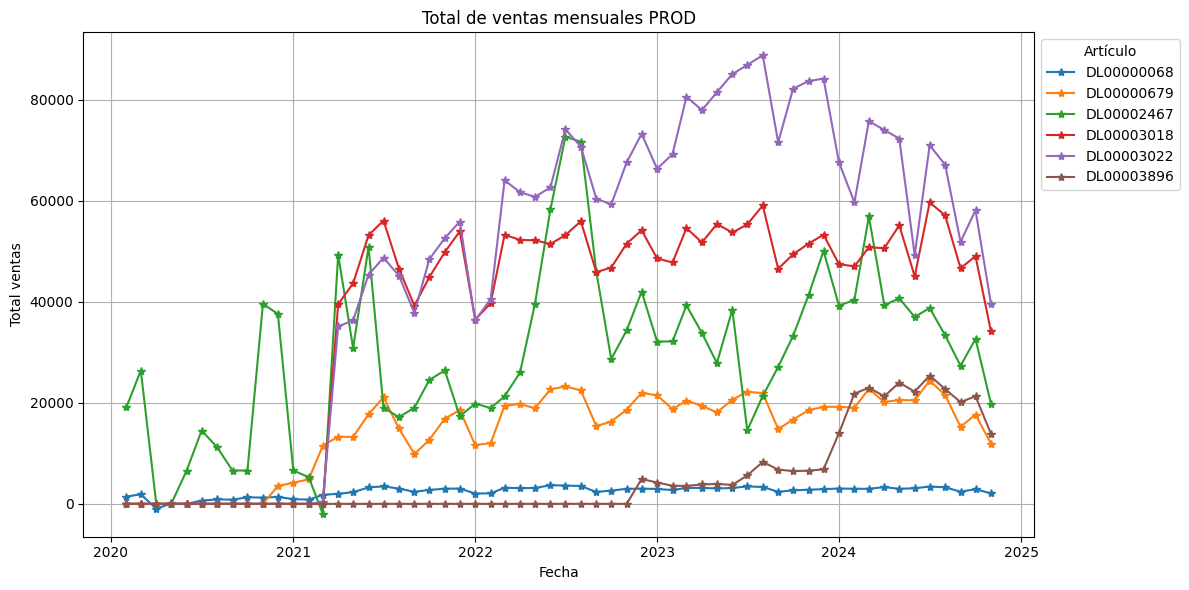

In [7]:
# Graficar los datos por articulo de tipo COMS
plt.figure(figsize=(12, 6))

# Agregar etiquetas por cada linea
for column in coms_monthly.columns:
    plt.plot(coms_monthly.index, coms_monthly[column], marker="*", linestyle="-", label=column)

plt.title("Total de ventas mensuales COMS")
plt.xlabel("Fecha")
plt.ylabel("Total ventas")
plt.legend(title="Artículo", loc="upper left", bbox_to_anchor=(1, 1))  # Add a legend with labels
plt.grid()
plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()

# Graficar los datos por articulo de tipo PROD
plt.figure(figsize=(12, 6))

# Agregar etiquetas por cada linea
for column in prod_monthly.columns:
    plt.plot(prod_monthly.index, prod_monthly[column], marker="*", linestyle="-", label=column)

plt.title("Total de ventas mensuales PROD")
plt.xlabel("Fecha")
plt.ylabel("Total ventas")
plt.legend(title="Artículo", loc="upper left", bbox_to_anchor=(1, 1))  # Add a legend with labels
plt.grid()
plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()


In [8]:
# Definir la frecuencia de la fecha a predecir para los articulos COMS
coms_monthly = coms_monthly.asfreq("MS")

# Almacenar las predicciones por articulo
forecast_results = {}

# Aplicando ARIMA (AutoRegressive Integrated Moving Average)
for article in coms_monthly.columns:
    article_sales = coms_monthly[article]
    
    if article_sales[article_sales != 0].count() > 12: 
        try:
            model = ARIMA(article_sales, order=(1, 1, 1))
            model_fit = model.fit()

            forecast = model_fit.get_forecast(steps=12)
            forecast_index = pd.date_range(article_sales.index[-1] + pd.DateOffset(months=1), 
                                           periods=12, freq="MS")
            forecast_series = forecast.predicted_mean
            forecast_conf_int = forecast.conf_int()
            
            forecast_results[article] = pd.DataFrame({
                "Forecast": forecast_series,
                "Lower CI": forecast_conf_int.iloc[:, 0],
                "Upper CI": forecast_conf_int.iloc[:, 1]
            }, index=forecast_index)
        except Exception as e:
            forecast_results[article] = f"Error: {e}"

# Combine forecasts into a single dataset for export
forecast_combined = pd.concat(forecast_results, axis=1)

# Export the results to a CSV file
forecast_output_path_articles = "data/ARIMA_Forecast_Articulo_COMS.csv"
forecast_combined.to_csv(forecast_output_path_articles)
forecast_output_path_articles


'data/ARIMA_Forecast_Articulo_COMS.csv'

In [9]:
# Definir la frecuencia de la fecha a predecir para los articulos PROD
prod_monthly = prod_monthly.asfreq("MS")

# Almacenar las predicciones por articulo
forecast_results = {}

# Aplicando ARIMA (AutoRegressive Integrated Moving Average)
for article in prod_monthly.columns:
    article_sales = prod_monthly[article]
    
    if article_sales[article_sales != 0].count() > 12: 
        try:
            model = ARIMA(article_sales, order=(1, 1, 1))
            model_fit = model.fit()

            forecast = model_fit.get_forecast(steps=12)
            forecast_index = pd.date_range(article_sales.index[-1] + pd.DateOffset(months=1), 
                                           periods=12, freq="MS")
            forecast_series = forecast.predicted_mean
            forecast_conf_int = forecast.conf_int()
            
            forecast_results[article] = pd.DataFrame({
                "Forecast": forecast_series,
                "Lower CI": forecast_conf_int.iloc[:, 0],
                "Upper CI": forecast_conf_int.iloc[:, 1]
            }, index=forecast_index)
        except Exception as e:
            forecast_results[article] = f"Error: {e}"

# Combine forecasts into a single dataset for export
forecast_combined = pd.concat(forecast_results, axis=1)

# Export the results to a CSV file
forecast_output_path_articles = "data/ARIMA_Forecast_Articulo_PROD.csv"
forecast_combined.to_csv(forecast_output_path_articles)
forecast_output_path_articles


'data/ARIMA_Forecast_Articulo_PROD.csv'